In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications as app
import tensorflow.config as tfconfig
import matplotlib.pyplot as plt
import gc, os
from PIL import Image
import numpy as np

In [2]:
MEMORY_LIMIT = 1024*3
try:
    gpus = tfconfig.list_physical_devices("GPU")
    if gpus:
        tfconfig.experimental.set_virtual_device_configuration(
            gpus[0],
            [tfconfig.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)]
        )
        print(f"GPU is set to {MEMORY_LIMIT/1024}GB")
except RuntimeError as e:
    print(e)

GPU is set to 3.0GB


In [3]:
dataset_dir = "D:\\repository\\AgriMitra\datasets\\archive\\PlantVillage"  # Replace with the actual path
model_save_path = "D:\\repository\\agrimitra_\\models"
epoch = 10
test_image = "D:\\repository\\AgriMitra\\datasets\\archive\\PlantVillage\\Pepper__bell___Bacterial_spot\\0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG"

In [4]:
# Set image size and batch size
img_size = (128, 128)  # You can change this according to your preference
batch_size = 32

In [5]:
# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values between 0 and 1
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom in on images
    horizontal_flip=True,     # Randomly flip images horizontally
    validation_split=0.2      # Use 20% of data for validation
)

In [6]:
# Train and validation data generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    shuffle=True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',   # Use 'categorical' for multi-class classification
    subset='training'
)

Found 16516 images belonging to 15 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    shuffle=True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 4122 images belonging to 15 classes.


In [8]:
class CropDisease(tf.keras.Model):
    def __init__(self,model):
        super(CropDisease,self).__init__()
        
        self.base_model = model(include_top=False, input_shape=(128, 128, 3))

        self.flatten = tf.keras.layers.Flatten()

        self.fc1 = tf.keras.layers.Dense(500, activation='leaky_relu')
        self.fc2 = tf.keras.layers.Dense(500, activation='relu')

        self.output_layer = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')

    def call(self, inputs):
        x = self.base_model(inputs)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        
        return self.output_layer(x)
        

In [9]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()
    # tf.compact.v1.reset_default_graph()

def plot_graph(history):
    # Plot training & validation accuracy
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training & validation loss
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(model):
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

def save_model(model, model_name):
    model.save(os.path.join(model_save_path,model_name), save_format='tf')

def load_model(path):
    return tf.keras.models.load_model(path)

def predict(model,img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    return model.predict(img)

def train_model(model,epoch=10):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epoch  # You can increase this for better performance
    )
    return history

## Training with VGG16

In [10]:
clear_memory()

base_model = app.VGG16
model = CropDisease(base_model)
model.build((None, 128, 128, 3))

model.summary()

Model: "crop_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  4096500   
                                                                 
 dense_1 (Dense)             multiple                  250500    
                                                                 
 dense_2 (Dense)             multiple                  7515      
                                                                 
Total params: 19,069,203
Trainable params: 19,069,203
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    loss='categorical_crossentropy',  # For multi-class classification
    optimizer='adam',  # Adam optimizer
    metrics=['accuracy']
)

In [12]:
history = train_model(model,epoch)

Epoch 1/10
516/516 [==============================] - 156s 288ms/step - loss: 2.3048 - accuracy: 0.2268 - val_loss: 1.9203 - val_accuracy: 0.3474
Epoch 2/10
516/516 [==============================] - 145s 281ms/step - loss: 1.8633 - accuracy: 0.3684 - val_loss: 1.5960 - val_accuracy: 0.4700
Epoch 3/10
516/516 [==============================] - 142s 275ms/step - loss: 1.6125 - accuracy: 0.4488 - val_loss: 1.5850 - val_accuracy: 0.4402
Epoch 4/10
516/516 [==============================] - 142s 275ms/step - loss: 1.3928 - accuracy: 0.5227 - val_loss: 1.2907 - val_accuracy: 0.5610
Epoch 5/10
516/516 [==============================] - 142s 275ms/step - loss: 1.4007 - accuracy: 0.5255 - val_loss: 1.2338 - val_accuracy: 0.5901
Epoch 6/10
516/516 [==============================] - 142s 275ms/step - loss: 1.1248 - accuracy: 0.6146 - val_loss: 0.9382 - val_accuracy: 0.6782
Epoch 7/10
516/516 [==============================] - 142s 275ms/step - loss: 0.9987 - accuracy: 0.6592 - val_loss: 0.8514 -

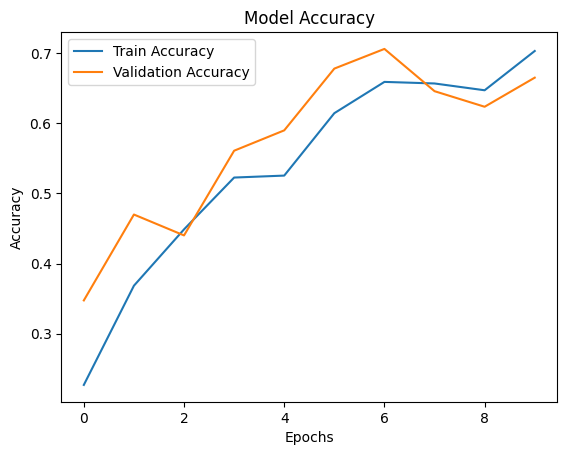

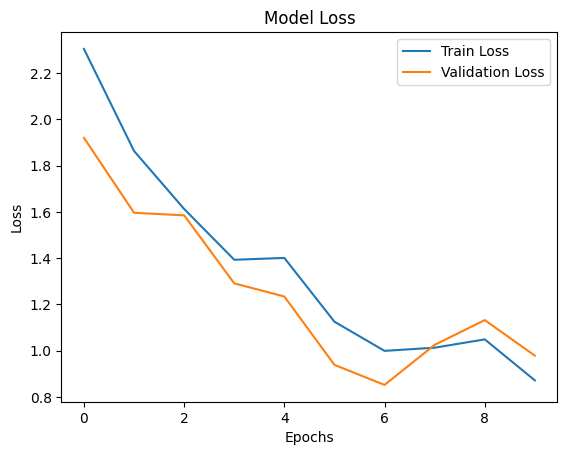

In [13]:
plot_graph(history.history)

In [14]:
evaluate(model)

129/129 [==============================] - 19s 148ms/step - loss: 0.9649 - accuracy: 0.6764
Test Loss: 0.9648857712745667
Test Accuracy: 0.6763706803321838


In [15]:
save_model(model,f"crop_disease-VGG16-{epoch}_epoch")

INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-VGG16-10_epoch\assets


INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-VGG16-10_epoch\assets


In [16]:
predict(model,test_image)

1/1 [==============================] - 1s 1s/step


array([[5.4570664e-02, 7.2484040e-03, 7.4782252e-02, 1.6859858e-01,
        4.1333172e-03, 4.1045240e-04, 1.6719446e-01, 2.4109529e-01,
        4.4506587e-02, 9.0273969e-02, 1.3152741e-01, 1.4219516e-02,
        1.2181338e-03, 4.4402072e-06, 2.1647378e-04]], dtype=float32)

## Training with VGG19

In [17]:
clear_memory()

base_model = app.VGG19
model = CropDisease(base_model)
model.build((None, 128, 128, 3))

model.summary()

Model: "crop_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  4096500   
                                                                 
 dense_1 (Dense)             multiple                  250500    
                                                                 
 dense_2 (Dense)             multiple                  7515      
                                                                 
Total params: 24,378,899
Trainable params: 24,378,899
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    loss='categorical_crossentropy',  # For multi-class classification
    optimizer='adam',  # Adam optimizer
    metrics=['accuracy']
)

In [19]:
history = train_model(model,epoch)

Epoch 1/10
516/516 [==============================] - 171s 329ms/step - loss: 2.2785 - accuracy: 0.2609 - val_loss: 1.8148 - val_accuracy: 0.4099
Epoch 2/10
516/516 [==============================] - 172s 333ms/step - loss: 1.8141 - accuracy: 0.4069 - val_loss: 1.8791 - val_accuracy: 0.3528
Epoch 3/10
516/516 [==============================] - 176s 340ms/step - loss: 1.7451 - accuracy: 0.4015 - val_loss: 1.5392 - val_accuracy: 0.4712
Epoch 4/10
516/516 [==============================] - 171s 331ms/step - loss: 1.4443 - accuracy: 0.5177 - val_loss: 1.2749 - val_accuracy: 0.5664
Epoch 5/10
516/516 [==============================] - 171s 330ms/step - loss: 1.2781 - accuracy: 0.5734 - val_loss: 1.1530 - val_accuracy: 0.6003
Epoch 6/10
516/516 [==============================] - 171s 330ms/step - loss: 1.1073 - accuracy: 0.6236 - val_loss: 1.0229 - val_accuracy: 0.6497
Epoch 7/10
516/516 [==============================] - 171s 330ms/step - loss: 1.0754 - accuracy: 0.6346 - val_loss: 0.9291 -

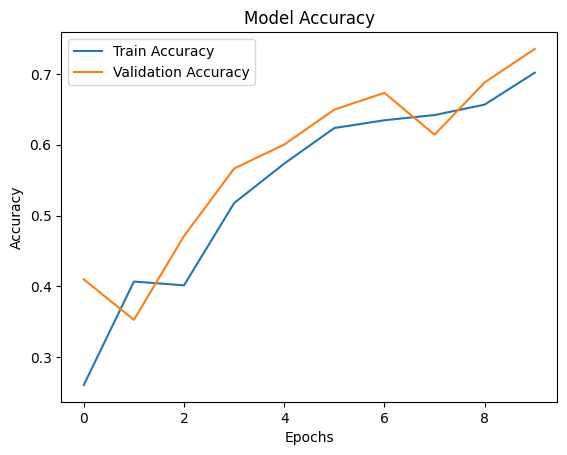

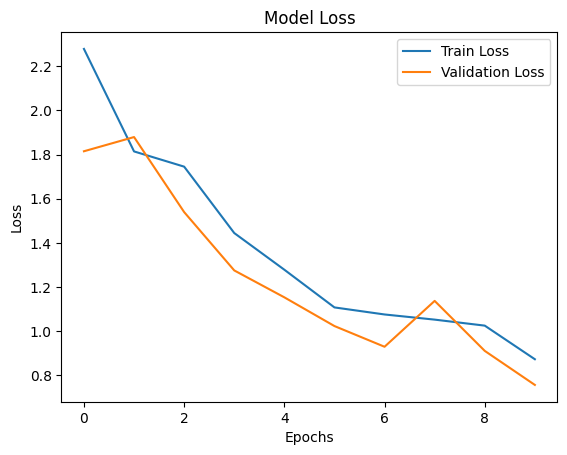

In [20]:
plot_graph(history.history)

In [21]:
evaluate(model)

129/129 [==============================] - 18s 138ms/step - loss: 0.7593 - accuracy: 0.7380
Test Loss: 0.7592692971229553
Test Accuracy: 0.7379912734031677


In [22]:
save_model(model,f"crop_disease-VGG19-{epoch}_epoch")

INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-VGG19-10_epoch\assets


INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-VGG19-10_epoch\assets


In [23]:
predict(model,test_image)

1/1 [==============================] - 0s 156ms/step


array([[2.0269528e-01, 6.3545680e-01, 7.2826818e-04, 4.5118639e-03,
        1.8839735e-03, 3.7648738e-03, 3.8437802e-02, 8.4220767e-02,
        1.3260828e-02, 9.8475404e-03, 5.5533909e-04, 4.5983936e-04,
        4.1696932e-03, 1.1514521e-07, 6.9494217e-06]], dtype=float32)

## Training with ResNet50

In [24]:
clear_memory()

base_model = app.ResNet50
model = CropDisease(base_model)
model.build((None, 128, 128, 3))

model.summary()

Model: "crop_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  16384500  
                                                                 
 dense_1 (Dense)             multiple                  250500    
                                                                 
 dense_2 (Dense)             multiple                  7515      
                                                                 
Total params: 40,230,227
Trainable params: 40,177,107
Non-trainable params: 53,120
_________________________________________________________________


In [25]:
model.compile(
    loss='categorical_crossentropy',  # For multi-class classification
    optimizer='adam',  # Adam optimizer
    metrics=['accuracy']
)

In [26]:
history = train_model(model,epoch)

Epoch 1/10
516/516 [==============================] - 137s 251ms/step - loss: 1.2077 - accuracy: 0.6750 - val_loss: 157.5118 - val_accuracy: 0.0461
Epoch 2/10
516/516 [==============================] - 134s 260ms/step - loss: 0.7729 - accuracy: 0.7688 - val_loss: 3.5668 - val_accuracy: 0.2988
Epoch 3/10
516/516 [==============================] - 133s 257ms/step - loss: 0.4989 - accuracy: 0.8414 - val_loss: 3.2782 - val_accuracy: 0.3604
Epoch 4/10
516/516 [==============================] - 134s 260ms/step - loss: 0.4830 - accuracy: 0.8463 - val_loss: 1.2498 - val_accuracy: 0.5996
Epoch 5/10
516/516 [==============================] - 137s 264ms/step - loss: 0.4396 - accuracy: 0.8562 - val_loss: 5.6054 - val_accuracy: 0.2744
Epoch 6/10
516/516 [==============================] - 260s 504ms/step - loss: 0.5242 - accuracy: 0.8309 - val_loss: 1.0280 - val_accuracy: 0.6956
Epoch 7/10
516/516 [==============================] - 215s 417ms/step - loss: 0.4476 - accuracy: 0.8531 - val_loss: 1.5996

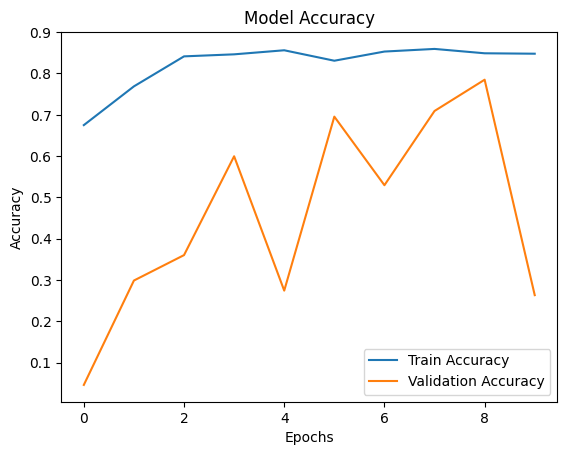

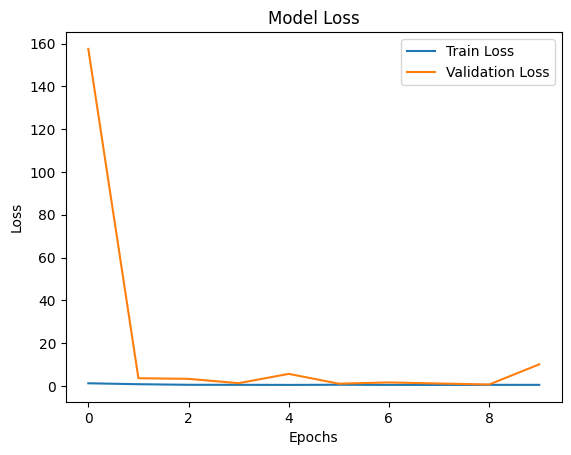

In [27]:
plot_graph(history.history)

In [28]:
evaluate(model)

129/129 [==============================] - 22s 173ms/step - loss: 10.0536 - accuracy: 0.2635
Test Loss: 10.053631782531738
Test Accuracy: 0.2634643316268921


In [29]:
save_model(model,f"crop_disease-ResNet50-{epoch}_epoch")

INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-ResNet50-10_epoch\assets


INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-ResNet50-10_epoch\assets


In [30]:
predict(model,test_image)

1/1 [==============================] - 2s 2s/step


array([[2.1330987e-15, 9.9973649e-01, 2.0207799e-22, 9.2946662e-18,
        4.7532514e-17, 9.9050390e-10, 4.3170028e-13, 5.9632461e-05,
        5.4487314e-11, 5.5668188e-14, 6.9291649e-11, 7.5242199e-15,
        1.0599223e-06, 2.9614636e-26, 2.0289049e-04]], dtype=float32)

## Training with MobileNetV2

In [31]:
clear_memory()

base_model = app.MobileNetV2
model = CropDisease(base_model)
model.build((None, 128, 128, 3))

model.summary()

Model: "crop_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  10240500  
                                                                 
 dense_1 (Dense)             multiple                  250500    
                                                                 
 dense_2 (Dense)             multiple                  7515      
                                                                 
Total params: 12,756,499
Trainable params: 12,722,387
Non-trainable params: 34,112
_____________________________________

In [32]:
model.compile(
    loss='categorical_crossentropy',  # For multi-class classification
    optimizer='adam',  # Adam optimizer
    metrics=['accuracy']
)

In [33]:
history = train_model(model,epoch)

Epoch 1/10
516/516 [==============================] - 121s 222ms/step - loss: 0.9357 - accuracy: 0.7702 - val_loss: 52.4616 - val_accuracy: 0.1560
Epoch 2/10
516/516 [==============================] - 90s 175ms/step - loss: 0.4102 - accuracy: 0.8843 - val_loss: 4.9667 - val_accuracy: 0.4604
Epoch 3/10
516/516 [==============================] - 90s 175ms/step - loss: 0.2616 - accuracy: 0.9217 - val_loss: 4.9809 - val_accuracy: 0.4094
Epoch 4/10
516/516 [==============================] - 119s 230ms/step - loss: 0.2883 - accuracy: 0.9193 - val_loss: 6.0202 - val_accuracy: 0.3743
Epoch 5/10
516/516 [==============================] - 118s 228ms/step - loss: 0.2179 - accuracy: 0.9364 - val_loss: 4.3993 - val_accuracy: 0.4148
Epoch 6/10
516/516 [==============================] - 97s 188ms/step - loss: 0.2424 - accuracy: 0.9299 - val_loss: 2.2625 - val_accuracy: 0.5806
Epoch 7/10
516/516 [==============================] - 101s 195ms/step - loss: 0.1614 - accuracy: 0.9534 - val_loss: 1.7178 - v

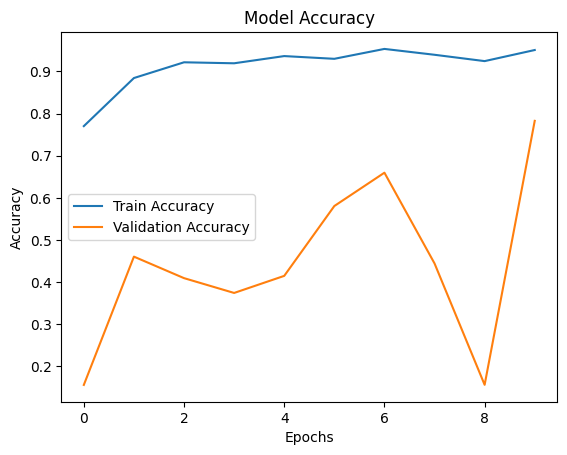

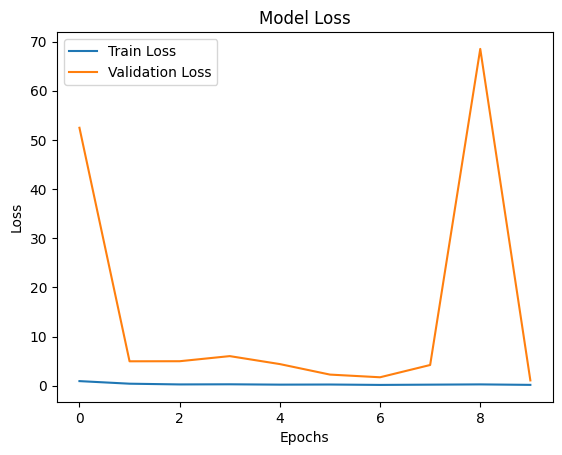

In [34]:
plot_graph(history.history)

In [35]:
evaluate(model)

129/129 [==============================] - 19s 146ms/step - loss: 1.1905 - accuracy: 0.7804
Test Loss: 1.1905001401901245
Test Accuracy: 0.7804464101791382


In [36]:
save_model(model,f"crop_disease-MobileNetV2-{epoch}_epoch")

INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-MobileNetV2-10_epoch\assets


INFO:tensorflow:Assets written to: D:\repository\agrimitra_\models\crop_disease-MobileNetV2-10_epoch\assets


In [37]:
predict(model,test_image)

1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00, 2.9323452e-10, 2.9333241e-10, 8.8969583e-14,
        9.2359937e-19, 7.3073869e-19, 5.0512784e-13, 3.1350519e-17,
        5.2819010e-18, 4.3099743e-11, 1.3942902e-16, 4.5178718e-12,
        1.4184606e-13, 3.5466146e-18, 2.8255848e-15]], dtype=float32)